In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (update the path as needed)
file_path = "/content/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# Clean column names to remove leading/trailing spaces
df.columns = df.columns.str.strip()

# Check if 'Humanitarian_Class' exists
if "Humanitarian_Class" not in df.columns:
    raise KeyError("Column 'Humanitarian_Class' not found in the dataset. Please check the column names.")

# Perform stratified splitting based on 'Humanitarian_Class' (5 classes)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Humanitarian_Class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Humanitarian_Class"], random_state=42)

# Save the split datasets
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

# Create a structured summary table
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Humanitarian_Class"].value_counts(),
    "Validation (15%)": val_df["Humanitarian_Class"].value_counts(),
    "Test (15%)": test_df["Humanitarian_Class"].value_counts(),
    "Total": df["Humanitarian_Class"].value_counts()
}).T

# Save the summary table
split_summary.to_csv("split_summary.csv")

print("Data split completed and saved as CSV files.")


Data split completed and saved as CSV files.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best RandomForest Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best RandomForest model saved.
Final Model Accuracy: 0.6203
Classification Report:
                                         precision    recall  f1-score   support

                  affected_individuals       0.40      0.52      0.45       163
rescue_volunteering_or_donation_effort       0.68      0.74      0.71       567
     infrastructure_and_utility_damage       0.38      0.43      0.40       224
            other_relevant_information       0.64      0.62      0.63       975
                      not_humanitarian       0.69      0.61      0.65       784

                              accuracy                           0.62      2713
                             macro avg       0.56      0.58      0.57      2713
                          weighted avg       0.63      0.62      0.62      2713



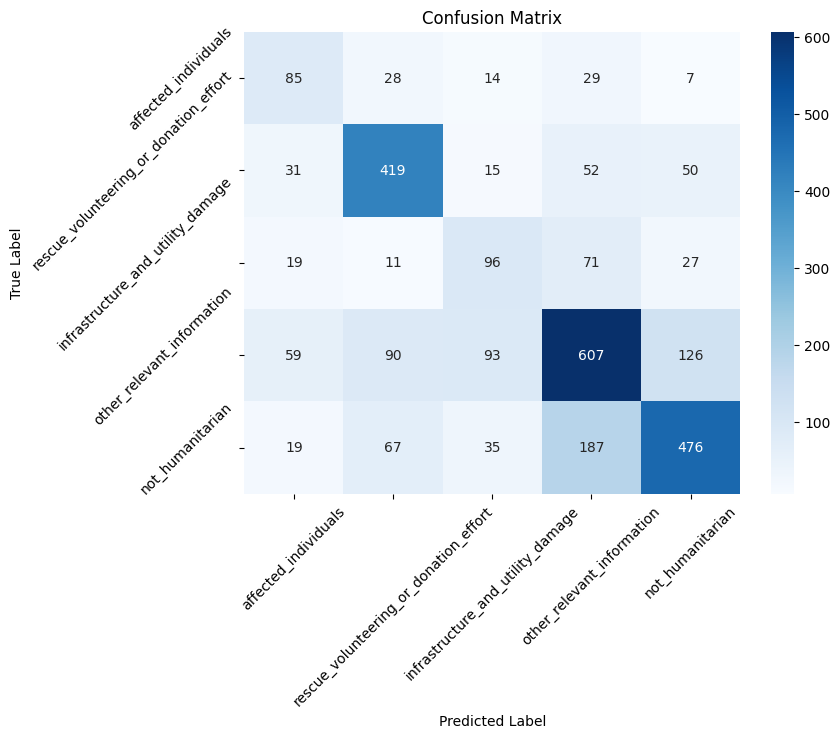

In [2]:
import pandas as pd
import numpy as np
import re
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Paths to data
train_path = "/content/train_data.csv"
val_path = "/content/val_data.csv"
test_path = "/content/test_data.csv"

# Load datasets
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# Normalize column names
for df in [train_df, val_df, test_df]:
    df.columns = df.columns.str.strip().str.lower()

# Define label mapping
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}

# Clean labels
for df in [train_df, val_df, test_df]:
    df['humanitarian_class'] = df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower()

# Convert labels to numeric
y_train = train_df['humanitarian_class'].map(label_map).astype(int)
y_test = test_df['humanitarian_class'].map(label_map).astype(int)

# Function to preprocess tweets
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^a-z\s]", "", text)  # Keep only letters
    return text.split()  # Tokenize

# Preprocess text
train_texts = train_df['tweet_text'].fillna("").apply(preprocess_text)
test_texts = test_df['tweet_text'].fillna("").apply(preprocess_text)

# Train Word2Vec Model
w2v_model = Word2Vec(sentences=train_texts, vector_size=200, window=5, min_count=1, workers=4, sg=1)
w2v_model.save("word2vec_model.bin")

# Convert text to Word2Vec embeddings
def text_to_w2v_vector(text, model, vector_size=200):
    words = [word for word in text if word in model.wv]
    return np.mean(model.wv[words], axis=0) if words else np.zeros(vector_size)

# Convert datasets to embeddings
X_train = np.array([text_to_w2v_vector(text, w2v_model) for text in train_texts])
X_test = np.array([text_to_w2v_vector(text, w2v_model) for text in test_texts])

# Feature Engineering
train_df['tweet_length'] = train_df['tweet_text'].apply(lambda x: len(str(x)))
train_df['num_hashtags'] = train_df['tweet_text'].apply(lambda x: str(x).count("#"))
train_df['num_mentions'] = train_df['tweet_text'].apply(lambda x: str(x).count("@"))

test_df['tweet_length'] = test_df['tweet_text'].apply(lambda x: len(str(x)))
test_df['num_hashtags'] = test_df['tweet_text'].apply(lambda x: str(x).count("#"))
test_df['num_mentions'] = test_df['tweet_text'].apply(lambda x: str(x).count("@"))

# Standardize features
scaler = StandardScaler()
X_train_features = scaler.fit_transform(train_df[['tweet_length', 'num_hashtags', 'num_mentions']])
X_test_features = scaler.transform(test_df[['tweet_length', 'num_hashtags', 'num_mentions']])

# Combine embeddings with additional features
X_train_combined = np.hstack((X_train, X_train_features))
X_test_combined = np.hstack((X_test, X_test_features))

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

# Hyperparameter Tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
best_rf = random_search.best_estimator_
print("Best RandomForest Parameters:", random_search.best_params_)

# Train best model
best_rf.fit(X_train_resampled, y_train_resampled)

# Save model
joblib.dump(best_rf, "random_forest_best.pkl")
print("Best RandomForest model saved.")

# Make predictions
y_pred = best_rf.predict(X_test_combined)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=label_map.keys())
print(f'Final Model Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_rep)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
